In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import zuko
import torch

from helpers.distributions import *
from helpers.flow import *

In [30]:
import yaml

with open("test/test.yml") as stream:
    run_params = yaml.safe_load(stream)
print(run_params)

target_p = LO_angularity
x_range = (0, 1)

E0 = run_params["physics"]["E0"]
R = run_params["physics"]["R"]




{'LOSS': 'logMSE', 'MODE': 'UNIFORM_SAMPLES', 'architecture': {'hidden_features': [32, 32], 'num_aux': 1, 'num_trainable_params': 13510, 'num_transforms': 5}, 'hyperparams': {'batch_num_c': 8, 'batch_num_x': 128, 'epochs': 200, 'lr': 0.001, 'seed': 1}, 'physics': {'E0': 500, 'R': 0.4, 'target_p': '<function LO_angularity at 0x7f9194e00670>'}}


In [31]:
auxiliary_params = run_params["architecture"]["num_aux"]

flow = zuko.flows.NSF(features = auxiliary_params + 1, context=1, transforms= run_params["architecture"]["num_transforms"], hidden_features=run_params["architecture"]["hidden_features"])
flow.load_state_dict(torch.load("test/test_model", weights_only=True))
flow.eval()

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

/tmp/ipykernel_1891559/3768609325.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")


Text(0, 0.5, 'Aux 0')

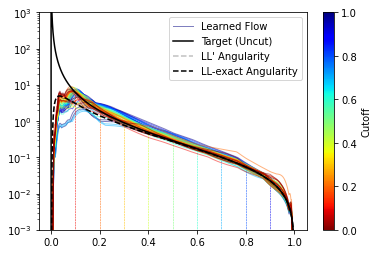

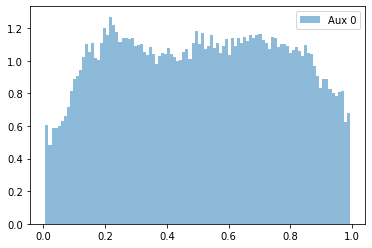

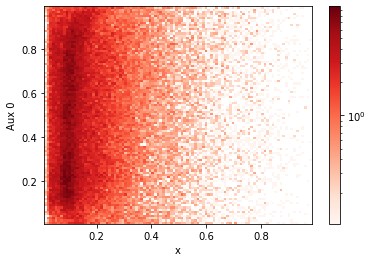

In [32]:
# Plot distribution of xs

fig, ax = plt.subplots(1,1)
cs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999][::-1]
# cs = [0.5]

DRAW_NF_HIST = False
DRAW_NF_LINES = True
aux_draws = 5


for i in range(len(cs)):


    # Draw hist
    c = torch.tensor((cs[i],))

    if DRAW_NF_HIST:
        samples = sigmoid(flow(c).sample((100000,)))
        x_samples = samples[:,0].detach().numpy()
        aux_samples = samples[:,1:].detach().numpy()

        jet_color = plt.get_cmap("jet")(  i / 10)
        if i == 0:
            label = "Generated Samples"
        else:
            label = None
        ax.hist(x_samples, bins=100, density=True, color = jet_color, alpha = 0.5, label = label, histtype="step")

    if DRAW_NF_LINES:

        for aux_draw in range(aux_draws):
            xs = torch.rand(10000, auxiliary_params + 1) * (x_range[1] - x_range[0]) + x_range[0]
            
            # Sort the first column
            xs = xs[torch.argsort(xs[:,0])]
            xs[:,1:] = torch.rand(1) * torch.ones((10000, auxiliary_params))
            

            logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
            ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

            xs = xs[:,0].detach().numpy().flatten()
            ys = np.nan_to_num(ys.detach().numpy().flatten())

            jet_color = plt.get_cmap("jet")( i / 10)
            if i == 0 and aux_draw == 0:
                label = "Learned Flow"
            else:
                label = None

            ax.plot(xs, ys, color = jet_color, lw = 1, alpha = 0.5, label = label)

            ax.vlines(cs[i], 0, target_p(c, E0, R), color = jet_color, linestyle = "--", alpha = 0.25, lw = 0.5)



# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, label="Cutoff")




# c = torch.tensor((0.5,))
# xs = torch.zeros((10000, auxiliary_params + 1)) + 0.5
# xs[:,0] = torch.linspace(0.001, 0.999, 10000)
# logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
# ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

# print(flow(c).log_prob(inverse_sigmoid(xs)))
# print(ys)

# xs = xs[:,0].detach().numpy().flatten()
# ys = np.nan_to_num(ys.detach().numpy().flatten())
# ps = target_p(torch.tensor(xs)).detach().numpy().flatten()
# plt.plot(xs, ys, color = "red", label = "Learned Flow")
# print(ys.mean())

# c = c.detach().numpy()

cutoff = xs > 0.5

plt.plot(xs, target_p(torch.tensor(xs), E0, R), color = "Black", label = "Target (Uncut)")
plt.plot(xs, LL_angularity(torch.tensor(xs), E0, R), color = "black", linestyle = "--", label = "LL' Angularity", alpha = 0.25)
plt.plot(xs, LL_angularity(torch.tensor(xs), E0, R), color = "black", linestyle = "--", label = "LL-exact Angularity")


# cutoff_norm = np.trapz(ps * cutoff, xs)
# plt.plot(xs, cutoff * ps , color = "grey", label = rf"Target (Cut at $c$ = {cs[0]})")

plt.legend()

plt.yscale("log")

plt.ylim(1e-3, 1e3)

c = torch.tensor((0.5,))
samples = sigmoid(flow(c).sample((100000,)))
x_samples = samples[:,0].detach().numpy()
aux_samples = samples[:,1:].detach().numpy()


# plot the auxiliary variables
if auxiliary_params > 0:
    fig, ax = plt.subplots(1,1)
    for i in range(auxiliary_params):
        plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
        prob = flow(c).log_prob(samples).exp()
        # plt.scatter(aux_samples[:,i], prob.detach().numpy(), color = "red")
    plt.legend()

# correlation between auxiliary variable 1 and x
fig, ax = plt.subplots(1,1)
bar = ax.hist2d(x_samples, aux_samples[:,0], bins=100, density=True, norm=mpl.colors.LogNorm(), cmap="Reds")
plt.colorbar(bar[3])
plt.xlabel("x")
plt.ylabel("Aux 0")

